In [1]:
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from vf_portalytics.model import PredictionModel
from vf_portalytics.dataset import DataSet
from vf_portalytics.tool import create_train_test_sets, score_model, plot_feature_importance
from sklearn import linear_model, ensemble, svm

In [2]:
# we load data and create the basics
dataset = DataSet('ulnl_prod_20170613_history', path='/home/carst/')
df = dataset.data_df

In [3]:
# understanding the contents

In [4]:
# filtering the contents
# df = df[df['field_1'] >= 110]
# print("\nAfter status filter: We have %d df with %d features." % (df.shape[0], df.shape[1]))

date_mask = df['field_21'] > 201500
df = df[date_mask]
print("\nAfter week filter: %d rows with %d features." % (df.shape[0], df.shape[1]))

small_df_mask = df['baseline_units'] > 0
min_discount_mask = (df['discount_perc'] > 0.1) & (df['discount_perc'] < 55)
small_lift_mask = (df['lift'] > 1.2) & (df['lift'] < 40)

df = df[(small_df_mask) & (min_discount_mask) & (small_lift_mask)]
print("\nAfter discount & lift filter: %d rows with %d features." % (df.shape[0], df.shape[1]))

mechanism_msk = df['mechanism'].notnull()
df = df[mechanism_msk]
print("\nAfter mechanism filter: %d rows with %d features." % (df.shape[0], df.shape[1]))


After week filter: 244530 rows with 229 features.

After discount & lift filter: 141428 rows with 229 features.

After mechanism filter: 141428 rows with 229 features.


In [5]:
# creating a prediction model
prediction_model = PredictionModel('carst_example', path='/home/carst/')

# set the features (C = categoric value for dimensional features)
prediction_model.features = {
    'baseline_units': [],
    'total_baseline_units': [],  # total to check the complete size of the promotion
    'total_nr_products': [],  # total to check the complete size of the promotion
    'base_price': [],
    'discount_perc': [],
    'discount_amt': [],
    'account_id': ['C'],  # account
    'product_brandkey': ['C'],  # brand
    'product_6_bc': ['C'],  # segment
    'product_3_cat': ['C'],  # category
    'week_nr': ['C'],
    'mechanism': ['C'],
    'multi_buy_x': [],
    'multi_buy_y': [],
    # 'field_102401': [],
    'promotion_dimension_136': ['C'],
    'promotion_dimension_137': ['C'],
    # 'promotion_dimension_138': ['C']
}

# we predict the lift normally or log?
prediction_model.target = {'lift': ['log']}

# are we doing logarithmic prediction?
if 'log' in prediction_model.target['lift']:
    log = True
else:
    log = False

In [6]:
# only use the needed columns
used_column_list = list(set(prediction_model.features.keys() + prediction_model.target.keys()))
df = df[used_column_list]

In [7]:
# create a mask based on random selections or on a period
mask = np.random.rand(len(df)) < 0.8

# create train sets
train_df, train_lift, test_df, test_lift = create_train_test_sets(df, mask, prediction_model, prediction_target='lift')

# are we doing logarithmic predictions
if log:
    # we need to train everything based on the log value
    train_lift = train_lift.apply(np.log)


Train set: 113288
Test set: 28140


In [8]:
# create and train a regressor
regressor = ensemble.ExtraTreesRegressor(n_estimators=79,
                                         random_state=10,
                                         min_samples_split=4,
                                         n_jobs=-1)
regressor.fit(train_df, train_lift)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=4, min_weight_fraction_leaf=0.0,
          n_estimators=79, n_jobs=-1, oob_score=False, random_state=10,
          verbose=0, warm_start=False)

In [9]:
# predict the lift
predict_lift = regressor.predict(test_df)

if log:
    # if it was logarithmic, expand the lift again
    predict_lift = np.exp(predict_lift)

# score the model
score_model(predict_lift, test_lift, baseline=test_df['baseline_units'])

R²:0.483013430799
MAE:1.40812385732
MAPE:26.4076851031
Forecast error:21.6941600503


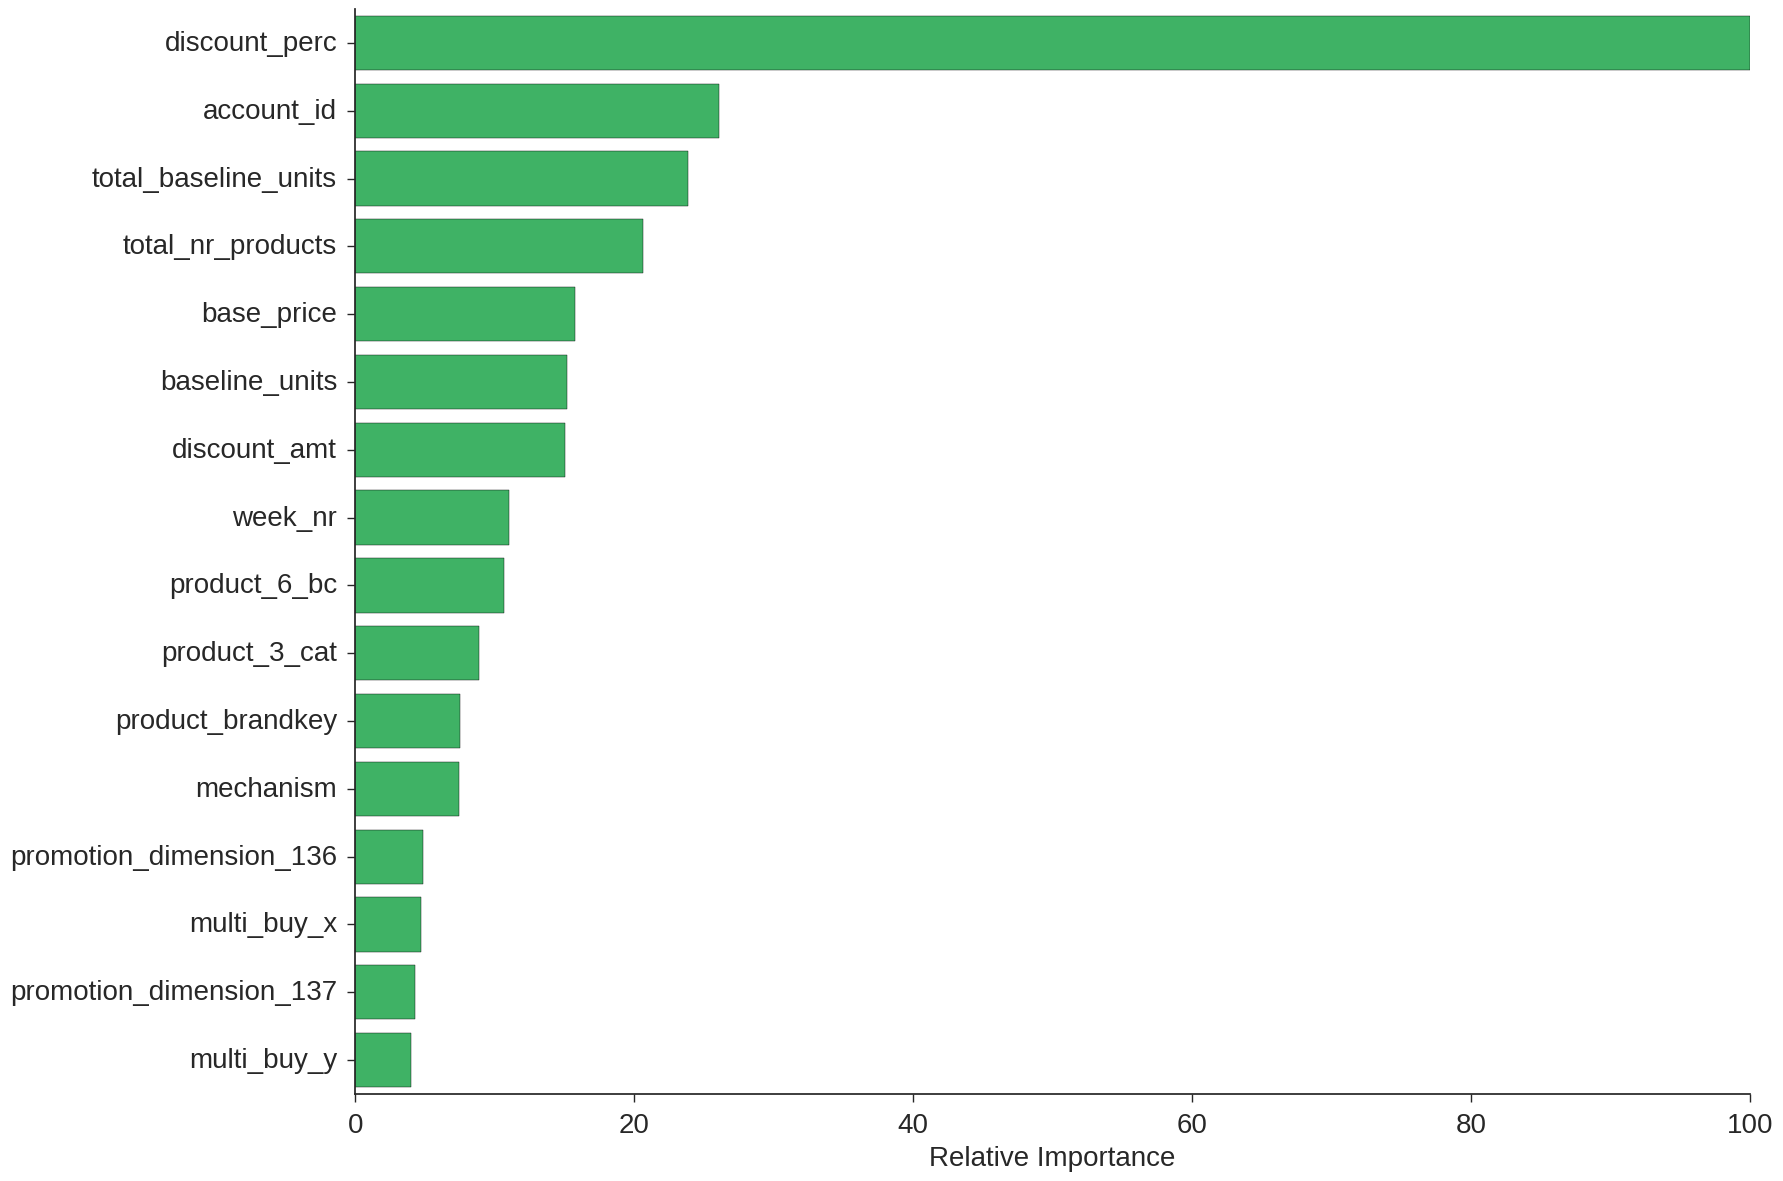

In [10]:
# check the feature importance
plot_feature_importance(regressor, train_df)

In [ ]:
# check where we are off
pass

In [ ]:
# save the model
prediction_model.save()